In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches
from tqdm import tqdm
import pickle

# module containing the main functions
import utils as ut
import utils_phase_diagr as ut_pd

In [8]:
# Parameters

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 100000, 'adapt', 25

# Memory stopping condition parameter
theta = 0.2  

# Fraction of ensambles with maximum to determine the non-monotoncity
no_max_perc = 0.9

# Minimal expansion factor
min_expans = 1.5

# Time of max expansion
t_T_max = 10

# Number of realizations in an ensemble
R = 1000

In [ ]:
# Computing the diagram (long time). Results saved in 'out_data/<name>.pkl'

# Defining the grid beta0 - alpha0
beta0s = np.logspace(-0.5, 0.75, 25)
alpha0s = np.logspace(-6, -2, 25)
sh = (len(beta0s), len(alpha0s))

# Initializing matrices to store results
data = {'beta0s': beta0s, 'alpha0s': alpha0s}
data['x_max_mat'] = np.zeros(sh) # Affinity of maximum abundace
data['outcome_mat'] = np.zeros(sh, dtype=object) # outcome type
data['frac_no_max_mat'] = np.zeros(sh) # fraction of runs with no maximum
data['taus_mat'] = np.zeros(sh, dtype=object) # values of taus
data['inv_imps'] = np.zeros(sh) # inverse of the Simpson index
data['T_tot'] = np.zeros(sh) # total memory cells at the peak
data['av_times'] = np.zeros(sh) # average time to the end of the simulation
data['t_T_max'] = np.zeros(sh) # average time of max expansion

# Computing the phase diagram
progress = tqdm(total=len(beta0s)*len(alpha0s))
for i, beta0 in enumerate(beta0s):
    for j, alpha0 in enumerate(alpha0s):

        # Generating ensamble
        ensamble = ut_pd.generate_ensamble(R, tau_samp, t_steps, dt, traj_steps, theta, print_progress=False, alpha0=alpha0, beta0=beta0)
        taus_mat, Ts_mat, T_tot_mat, times_mat = ensamble

        # Analyzing the ensamble and storing some observables
        if alpha0 > 5e-4: qt = 0.995 # Setting the sensitivty to outliers depending on alpha0)
        else: qt = 0.999
        x_max, y_max, n_x_max, outcome = ut_pd.find_max(taus_mat, Ts_mat, smooth_bins=50, quantile_taus=qt)
        data['x_max_mat'][i,j], data['outcome_mat'][i,j] = x_max, outcome
        data['frac_no_max_mat'][i,j] = (R - n_x_max) / R
        data['av_times'][i,j] = np.mean([t[-1] for t in times_mat])
        data['T_tot'][i,j] = np.mean([np.max(Ttot) for Ttot in T_tot_mat])
        data['t_T_max'][i,j] = np.mean([times_mat[r][np.argmax(T_tot_mat[r])] for r in range(R)])
        data['inv_imps'][i,j] = ut_pd.compute_inv_simps(Ts_mat)
        progress.update(1)

# Saving data with the observables
name = 'b0_a0_' + str(len(beta0s)*len(alpha0s))
with open(f'out_data/phase_diagram/{name}.pkl', 'wb') as f:
    pickle.dump(data, f)

# Saving parameters
pars = ut.TT_params([1])  # just to have access to default parameters
tau_samp = ut.tau_sampler_lognorm() 
other_params = {'theta_stop': theta, 'no_max_perc': no_max_perc, 'min_expans': min_expans, 'R' : R}
other_params = {**tau_samp.get_pars(), **other_params}
pars.print_on_file('out_data/phase_diagram/', name, other_params)

100%|██████████| 25/25 [51:50<00:00, 228.25s/it] 

In [11]:
name = 'b0_a0_25'

# Importing the parameters
params = pd.read_csv(f'out_data/phase_diagram/{name}.tsv', sep='\t', header=None, index_col=0)[1].to_dict()

# Importing the data
data = pickle.load(open(f'out_data/phase_diagram/{name}.pkl', 'rb'))
beta0s, alpha0s, x_max_mat, outcome_mat, frac_no_max_mat, simps_mat, Ttot_mat, t_T_max_mat = data['beta0s'], data['alpha0s'], data['x_max_mat'], data['outcome_mat'], data['frac_no_max_mat'], data['inv_imps'], data['T_tot'], data['t_T_max']

# Appling the thresholds
max_mask = outcome_mat == 'maximum'
outcome_mat[np.logical_and(max_mask, frac_no_max_mat > params['no_max_perc'])] = 'no_maximum'
outcome_mat[Ttot_mat < params['min_expans'] * tau_samp.n_samples] = 'extinct'

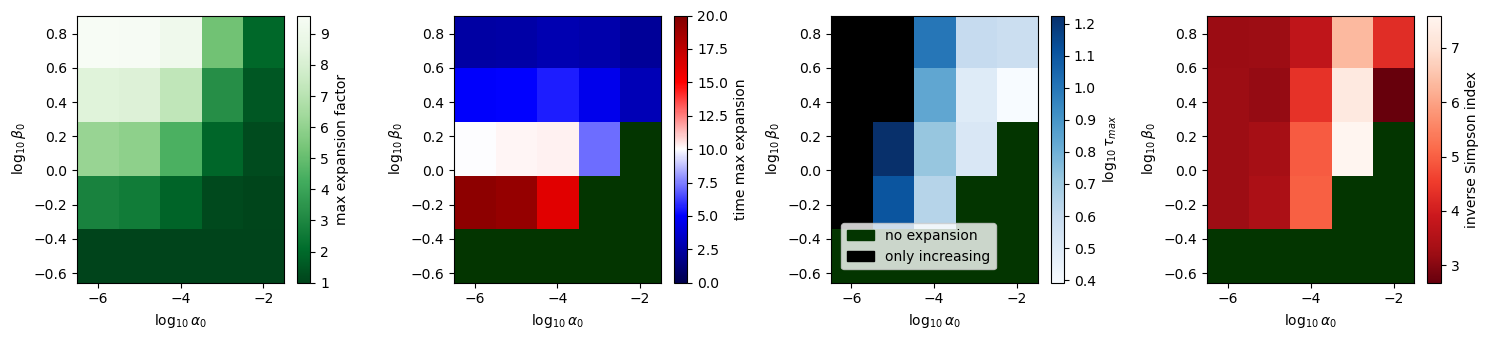

In [13]:
# Plotting the phase diagrams

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3.5))

xs, ys = np.log10(alpha0s), np.log10(beta0s)
extent = (xs[0] - (xs[1]-xs[0])/2, xs[-1] + (xs[1]-xs[0])/2, ys[0] - (ys[1]-ys[0])/2, ys[-1] + (ys[1]-ys[0])/2)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel(r'$\log_{10}\alpha_{0}$')
    ax.set_ylabel(r'$\log_{10}\beta_{0}$')  

ax1.imshow(Ttot_mat[::-1] / params['n_samples'], extent=extent, aspect='auto', cmap='Greens_r')
cb1 = fig.colorbar(ax1.images[0], ax=ax1)
cb1.set_label('max expansion factor')

# Centering the colormap around zero
delta = max(np.max(t_T_max_mat) - t_T_max, t_T_max - np.min(t_T_max_mat))
ax2.imshow(t_T_max_mat[::-1], extent=extent, aspect='auto', cmap='seismic', vmax=t_T_max + delta, vmin=t_T_max - delta)
ax2 = ut_pd.add_phases(ax2, outcome_mat, extent, add_increasing=False)
cb2 = fig.colorbar(ax2.images[0], ax=ax2)
cb2.set_label('time max expansion')

aux_mat = np.where(outcome_mat == 'maximum', x_max_mat, float('nan'))
ax3.imshow(aux_mat[::-1], extent=extent, aspect='auto', cmap='Blues')
ax3 = ut_pd.add_phases(ax3, outcome_mat, extent, legend=True)
cb3 = fig.colorbar(ax3.images[0], ax=ax3)
cb3.set_label(r'$\log_{10}\tau_{max}$')

aux_mat = np.where(outcome_mat != 'extinct', simps_mat, float('nan'))
ax4.imshow(aux_mat[::-1], extent=extent, aspect='auto', cmap='Reds_r')
ax4 = ut_pd.add_phases(ax4, outcome_mat, extent, add_increasing=False)
cb4 = fig.colorbar(ax4.images[0], ax=ax4)
cb4.set_label('inverse Simpson index')


plt.tight_layout()

plt.savefig('plots/phase_diagram/'+name+'.svg', dpi=200, facecolor='w')

In [ ]:
i,j = -4, -3
print(np.log10(beta0s[i]), np.log10(alpha0s[j]))
print()

0.75 -4.0
913.9159393531111


In [12]:
outcome_mat[i,j], frac_nomax_mat[i,j]

(np.str_('no_maximum'), np.float64(1.0))